# Simulated Data Reconstruction

This notebook demonstrates the process of reconstructing a complex field from simulated magnitude-only measurements using holographic phase retrieval, specifically the Gerchberg-Saxton (GS) algorithm with perturbation strategies.

## 1. Imports

Import necessary libraries, including standard Python modules, numerical libraries (NumPy), configuration management (Hydra, OmegaConf), and custom modules for the phase retrieval algorithm, utility functions, and visualization.

In [1]:
import logging
import os
import os.path
import pickle
import random

import hydra
import numpy as np
from omegaconf import DictConfig, OmegaConf

# Assuming 'src' is in the Python path or the notebook is run from the project root
from src.algorithms.gerchberg_saxton import holographic_phase_retrieval
from src.create_channel_matrix import create_channel_matrix
from src.create_test_pointcloud import create_test_pointcloud
from src.utils.field_utils import compute_fields, reconstruct_field
from src.visualization.field_plots import visualize_fields
from src.visualization.history_plots import (
    visualize_current_and_field_history,
    visualize_iteration_history,
)

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("__notebook__") # Use a notebook-specific logger name

## 2. Configuration Loading (Hydra)

Hydra is used for configuration management. We initialize Hydra within the notebook context. Note that running Hydra directly in a standard Jupyter environment can be tricky. A common workaround is to use `hydra.initialize` and `hydra.compose`.

**Important:** You might need to adjust the `config_path` relative to where you run the notebook.

In [2]:
from hydra import initialize, compose

# Clear previous Hydra instances if necessary (useful for re-running cells)
hydra.core.global_hydra.GlobalHydra.instance().clear()

# Initialize Hydra
# Adjust config_path relative to the notebook's location or project root
initialize(config_path="./conf", version_base="1.2")

# Compose the configuration
cfg = compose(config_name="simulated_data")

# Print the configuration (optional)
print(OmegaConf.to_yaml(cfg))

wavelength: 0.0107
plane_size: 1.0
resolution: 50
room_size: 2.0
use_source_pointcloud: false
source_pointcloud_path: measurement_data/source_pointcloud.pkl
pointcloud_downsample: 4
max_distance_from_origin: -1
wall_points: 10
num_sources: 100
perturb_points: true
perturbation_factor: 0.02
amplitude_sigma: 3.0
gs_iterations: 200
convergence_threshold: 0.001
regularization: 0.001
adaptive_regularization: true
perturbation_mode: basic
enable_perturbations: false
stagnation_window: 30
stagnation_threshold: 0.001
perturbation_intensity: 0.8
constraint_skip_iterations: 3
momentum_factor: 0.8
temperature: 5.0
verbose: false
return_history: true
show_plot: true
no_plot: false
no_anim: false
enable_smoothing: false
smoothing_radius_mm: 0.0



## 3. Setup Output Directory and Log Basic Info

Create a directory to store plots and log initial configuration details.

In [3]:
# Define output directory relative to the notebook or use an absolute path
output_dir = "./plots_simulated/" # Changed path to avoid conflict with script output
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
logger.info(f"Output directory for plots: {output_dir}")
logger.info(f"use_source_pointcloud: {cfg.use_source_pointcloud}")

INFO:__notebook__:Output directory for plots: ./plots_simulated/
INFO:__notebook__:use_source_pointcloud: False


## 4. Load or Create Point Cloud

Depending on the configuration (`cfg.use_source_pointcloud`), either load a pre-existing point cloud from a pickle file or generate a synthetic test point cloud.

In [4]:
if cfg.use_source_pointcloud:
    logger.info(f"Loading source point cloud from {cfg.source_pointcloud_path}...")
    # Ensure the path is correct relative to the notebook's execution location
    try:
        with open(cfg.source_pointcloud_path, "rb") as f:
            data = pickle.load(f)
        points = data[:, :3]
        logger.info(f"Loaded point cloud with {len(points)} points, shape: {points.shape}")
    except FileNotFoundError:
        logger.error(f"Error: Point cloud file not found at {cfg.source_pointcloud_path}. Please check the path.")
        # Handle the error appropriately, e.g., raise exception or use default
        points = None # Or set a default
    except Exception as e:
        logger.error(f"Error loading point cloud: {e}")
        points = None
else:
    logger.info("Creating test point cloud...")
    points = create_test_pointcloud(cfg)

if points is not None:
    logger.info(f"Using point cloud shape: {points.shape}")
else:
    logger.error("Point cloud could not be loaded or created. Stopping execution.")
    # Consider raising an error here to stop the notebook
    # raise ValueError("Point cloud is not available.")

INFO:__notebook__:Creating test point cloud...
INFO:__notebook__:Using point cloud shape: (600, 3)


## 5. Define Ground Truth Currents

Create the 'true' current distribution on the point cloud. This involves selecting a subset of points as sources and assigning them random amplitudes (log-normal distribution) and phases (uniform distribution). If no sources are specified, a default current is assigned.

In [5]:
# Ensure points exist before proceeding
if points is not None:
    currents = np.zeros(len(points), dtype=complex)

    num_sources = min(cfg.num_sources, len(currents))
    if num_sources > 0:
        source_indices = random.sample(range(len(currents)), num_sources)

        amplitudes = np.random.lognormal(mean=0, sigma=cfg.amplitude_sigma, size=num_sources)
        phases = np.random.uniform(0, 2 * np.pi, size=num_sources)

        for i, idx in enumerate(source_indices):
            currents[idx] = amplitudes[i] * np.exp(1j * phases[i])
        logger.info(f"Assigned currents to {num_sources} random sources.")
    else:
        # Default case if num_sources is 0 or points is empty
        if len(currents) > 0:
             currents[0] = 1.0 # Assign a default current if needed
             logger.info("Assigned default current to the first point.")
        else:
             logger.warning("Point cloud is empty, cannot assign currents.")
else:
    logger.error("Skipping current definition as point cloud is not available.")
    currents = None

INFO:__notebook__:Assigned currents to 100 random sources.


## 6. Define Measurement Plane

Create the 2D plane where the field measurements will be simulated. This is defined by its size and resolution based on the configuration.

In [6]:
logger.info("Creating measurement plane...")
x = np.linspace(-cfg.plane_size / 2, cfg.plane_size / 2, cfg.resolution)
y = np.linspace(-cfg.plane_size / 2, cfg.plane_size / 2, cfg.resolution)
X, Y = np.meshgrid(x, y)
measurement_plane = np.stack([X, Y, np.zeros_like(X)], axis=-1)
logger.info(f"Measurement plane shape: {measurement_plane.shape}")

INFO:__notebook__:Creating measurement plane...
INFO:__notebook__:Measurement plane shape: (50, 50, 3)


## 7. Calculate Wave Number and Channel Matrix

Calculate the wave number `k` based on the configured wavelength. Then, compute the channel matrix `H`, which models the propagation from each point in the source cloud to each point on the measurement plane.

In [7]:
k = 2 * np.pi / cfg.wavelength
logger.info(f"Wave number k: {k:.2f} (wavelength: {cfg.wavelength:.4f} m)")

# Ensure points exist before creating channel matrix
if points is not None:
    logger.info("Creating channel matrix...")
    H = create_channel_matrix(points, measurement_plane, k)
    logger.info(f"Channel matrix H shape: {H.shape}")
else:
    logger.error("Skipping channel matrix creation as point cloud is not available.")
    H = None

INFO:__notebook__:Wave number k: 587.21 (wavelength: 0.0107 m)
INFO:__notebook__:Creating channel matrix...
INFO:__notebook__:Channel matrix H shape: (2500, 600)


## 8. Calculate Ground Truth Field and Measured Magnitude

Compute the 'true' complex field on the measurement plane using the ground truth currents and the channel matrix. The magnitude of this true field serves as the simulated 'measurement' data for the phase retrieval algorithm.

In [8]:
# Ensure H and currents are available
if H is not None and currents is not None:
    logger.info("Calculating ground truth field...")
    true_field = compute_fields(points, currents, measurement_plane, k, H)
    true_field_2d = true_field.reshape(cfg.resolution, cfg.resolution)
    logger.info(f"True field shape: {true_field.shape}")

    measured_magnitude = np.abs(true_field)  # Use magnitude from synthetic true field
    measured_magnitude_2d = measured_magnitude.reshape(cfg.resolution, cfg.resolution)
    logger.info(f"Measured magnitude shape: {measured_magnitude.shape}")
else:
    logger.error("Skipping ground truth field calculation as prerequisites are missing.")
    true_field = None
    true_field_2d = None
    measured_magnitude = None
    measured_magnitude_2d = None

INFO:__notebook__:Calculating ground truth field...
INFO:__notebook__:True field shape: (2500,)
INFO:__notebook__:Measured magnitude shape: (2500,)


## 9. Run Holographic Phase Retrieval (Gerchberg-Saxton)

Execute the core phase retrieval algorithm (`holographic_phase_retrieval`) using the channel matrix `H` and the simulated `measured_magnitude`. The algorithm attempts to recover the phase information and reconstruct the source currents (cluster coefficients).

In [9]:
# Ensure H and measured_magnitude are available
if H is not None and measured_magnitude is not None:
    logger.info("Running holographic phase retrieval with perturbation strategies...")
    hpr_result = holographic_phase_retrieval(cfg, H, measured_magnitude, output_dir=output_dir)
    logger.info("Holographic phase retrieval finished.")
else:
    logger.error("Skipping phase retrieval as prerequisites are missing.")
    hpr_result = None

INFO:__notebook__:Running holographic phase retrieval with perturbation strategies...


GS Progress: 100.0%


INFO:__notebook__:Holographic phase retrieval finished.


## 10. Process and Log Results

Unpack the results from the phase retrieval process. Log statistics about the algorithm's performance, such as the number of iterations, final/best RMSE, and details about any perturbations applied.

In [11]:
if hpr_result is not None:
    if cfg.return_history:
        cluster_coefficients, coefficient_history, field_history, stats = hpr_result
        logger.info(f"Coefficient history shape: {coefficient_history.shape}")
        logger.info(f"Field history shape: {field_history.shape}")
    else:
        cluster_coefficients, stats = hpr_result
        coefficient_history, field_history = None, None # Ensure variables exist

    logger.info("Perturbation statistics:")
    logger.info(f"  Total iterations: {stats['iterations']}")
    logger.info(f"  Final RMSE: {stats['final_rmse']:.6f}")
    logger.info(f"  Best RMSE: {stats['best_rmse']:.6f}")
    logger.info(f"  Perturbations applied: {stats['num_perturbations']}")

    if stats.get("post_perturbation_tracking"):
        successful_perturbations = [
            p for p in stats["post_perturbation_tracking"] if p["success"]
        ]
        success_rate = (
            len(successful_perturbations) / len(stats["post_perturbation_tracking"])
            if stats["post_perturbation_tracking"]
            else 0
        )
        avg_improvement = (
            np.mean([p["improvement"] for p in successful_perturbations])
            if successful_perturbations
            else 0
        )
        logger.info(f"  Perturbation success rate: {success_rate:.2f}")
        logger.info(
            f"  Average improvement from successful perturbations: {avg_improvement:.6f}"
        )
else:
    logger.error("Phase retrieval did not run, cannot process results.")
    cluster_coefficients = None
    coefficient_history = None
    field_history = None
    stats = None

INFO:__notebook__:Coefficient history shape: (200, 600)
INFO:__notebook__:Field history shape: (200, 2500)
INFO:__notebook__:Perturbation statistics:
INFO:__notebook__:  Total iterations: 200
INFO:__notebook__:  Final RMSE: 0.101995
INFO:__notebook__:  Best RMSE: 0.097300
INFO:__notebook__:  Perturbations applied: 0


## 11. Generate History Animations (Optional)

If `cfg.return_history` is true and animations are not disabled (`cfg.no_anim`), generate GIF animations visualizing the evolution of the currents and fields throughout the Gerchberg-Saxton iterations.

INFO:__notebook__:Creating GS iteration animation...


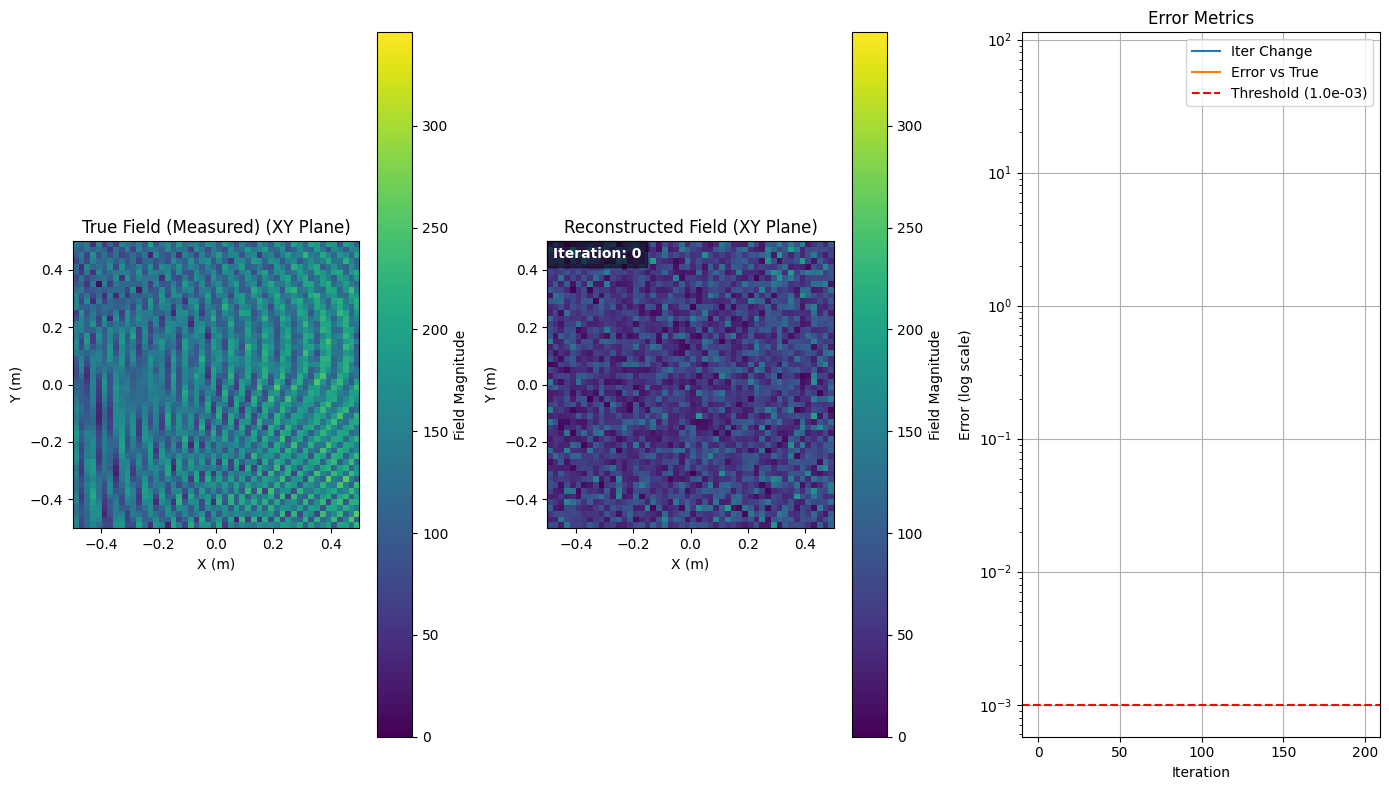

INFO:__notebook__:GS iteration animation saved to ./plots_simulated/gs_animation.gif
INFO:__notebook__:Creating enhanced 4-panel animation...


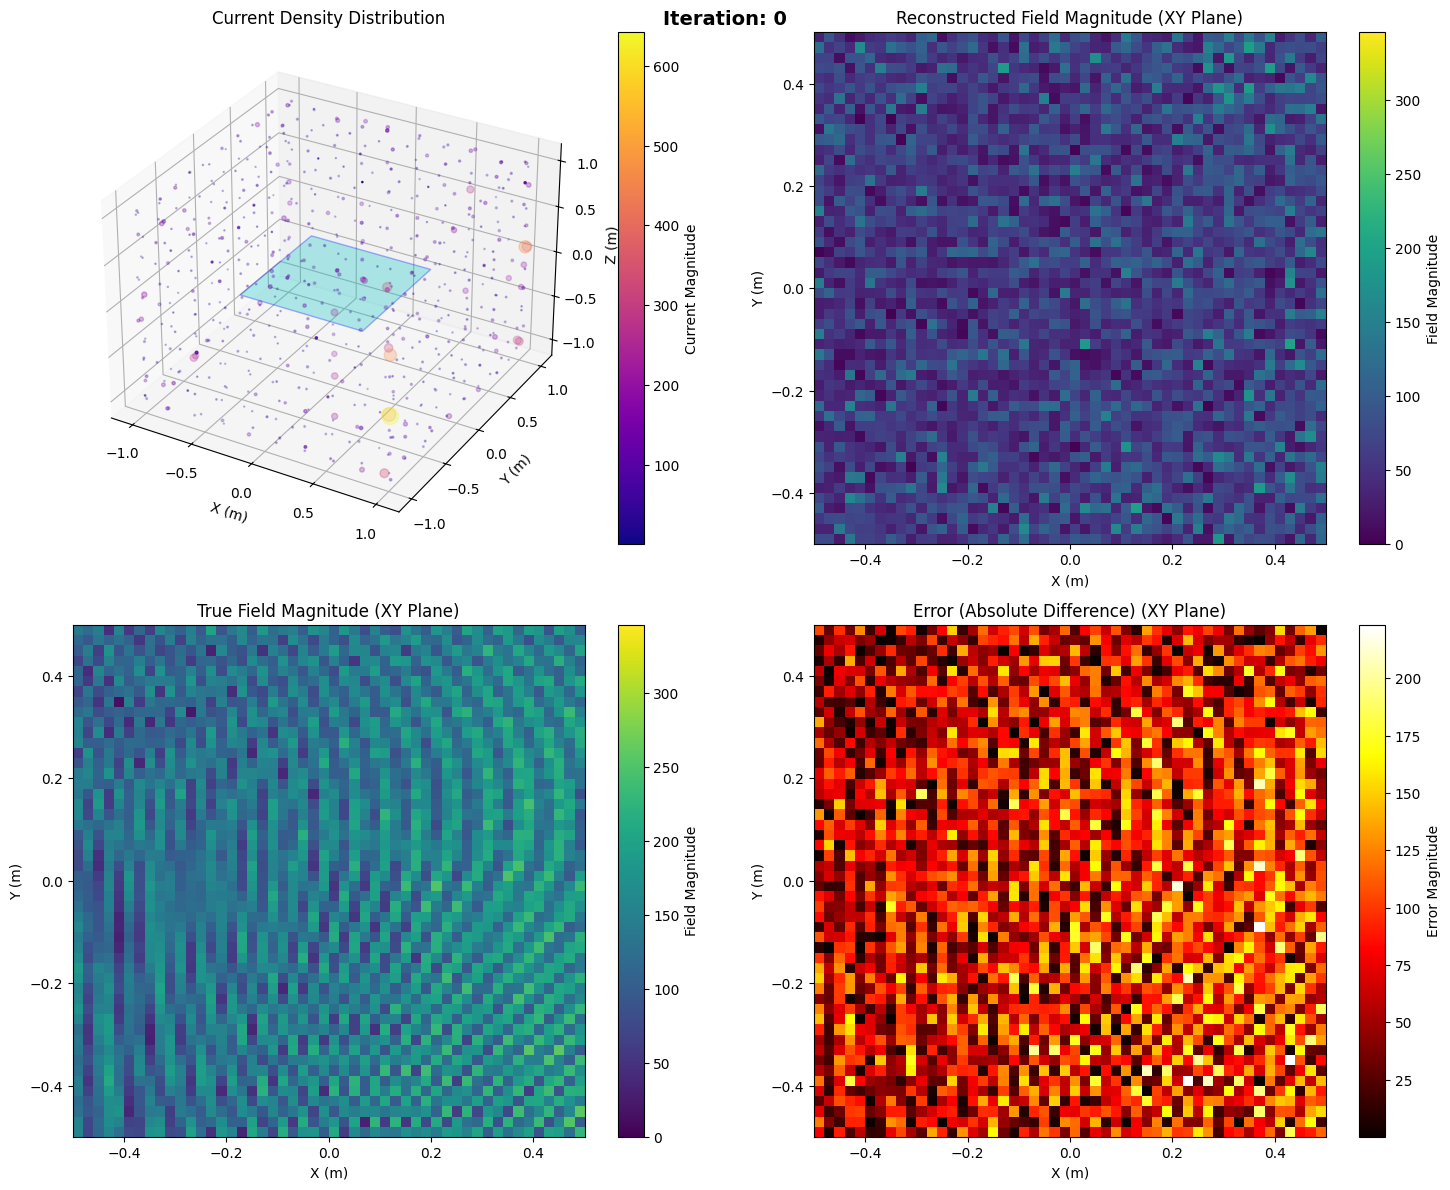

/home/codespace/.local/lib/python3.12/site-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(
INFO:__notebook__:Current/field animation saved to ./plots_simulated/current_field_animation.gif


In [12]:
if cfg.return_history and not cfg.no_anim and hpr_result is not None and points is not None and H is not None and measured_magnitude is not None and stats is not None:
    logger.info("Creating GS iteration animation...")
    try:
        visualize_iteration_history(
            points,
            H,
            coefficient_history,
            field_history,
            cfg.resolution,
            measurement_plane,
            show_plot=(cfg.show_plot and not cfg.no_plot),
            output_file=None, # Save directly to animation file
            animation_filename=os.path.join(output_dir, "gs_animation.gif"),
            frame_skip=10, # Increased frame skip for faster animation
            perturbation_iterations=stats.get("perturbation_iterations", []),
            restart_iterations=[], # No restarts in vanilla implementation
            convergence_threshold=cfg.convergence_threshold,
            measured_magnitude=measured_magnitude,
        )
        logger.info(f"GS iteration animation saved to {os.path.join(output_dir, 'gs_animation.gif')}")
    except Exception as e:
        logger.error(f"Error generating GS iteration animation: {e}")

    logger.info("Creating enhanced 4-panel animation...")
    try:
        visualize_current_and_field_history(
            points,
            coefficient_history,
            field_history,
            true_field, # Pass the synthetic true field for comparison
            cfg.resolution,
            measurement_plane,
            show_plot=(cfg.show_plot and not cfg.no_plot),
            output_file=None, # Save directly to animation file
            animation_filename=os.path.join(output_dir, "current_field_animation.gif"),
            # frame_skip=1 # Default frame skip might be better here
        )
        logger.info(f"Current/field animation saved to {os.path.join(output_dir, 'current_field_animation.gif')}")
    except Exception as e:
        logger.error(f"Error generating current/field animation: {e}")

elif cfg.no_anim:
    logger.info("Animation generation disabled via no_anim flag")
elif not cfg.return_history:
     logger.info("History not returned, skipping animation generation.")
else:
    logger.warning("Skipping animation generation due to missing prerequisites.")

## 12. Reconstruct Field and Calculate Metrics

Use the recovered `cluster_coefficients` and the channel matrix `H` to reconstruct the final complex field on the measurement plane. Calculate quality metrics (Normalized RMSE and Correlation) by comparing the magnitude of the reconstructed field to the magnitude of the ground truth field.

In [13]:
# Define helper functions for metrics
def normalized_rmse(a, b):
    if np.all(a == b): return 0.0 # Handle perfect match
    norm_factor = (np.max(a) - np.min(a))
    if norm_factor == 0: return np.sqrt(np.mean((a - b) ** 2)) # Avoid division by zero if 'a' is constant
    return np.sqrt(np.mean((a - b) ** 2)) / norm_factor

def normalized_correlation(a, b):
    a_flat = a.flatten()
    b_flat = b.flatten()
    if np.std(a_flat) == 0 or np.std(b_flat) == 0: return 1.0 if np.allclose(a,b) else 0.0 # Handle constant arrays
    a_norm = (a_flat - np.mean(a_flat)) / np.std(a_flat)
    b_norm = (b_flat - np.mean(b_flat)) / np.std(b_flat)
    # Ensure lengths match after flattening
    if len(a_norm) != len(b_norm):
        logger.error("Array lengths mismatch in normalized_correlation")
        return np.nan
    correlation = np.correlate(a_norm, b_norm)[0]
    return correlation / len(a_norm)

# Reconstruct and calculate metrics if possible
if H is not None and cluster_coefficients is not None and true_field is not None:
    logger.info("Reconstructing final field...")
    reconstructed_field = reconstruct_field(H, cluster_coefficients)
    reconstructed_field_2d = reconstructed_field.reshape(cfg.resolution, cfg.resolution)
    logger.info(f"Reconstructed field shape: {reconstructed_field.shape}")

    # Calculate metrics using the absolute values (magnitudes)
    true_magnitude = np.abs(true_field)
    reconstructed_magnitude = np.abs(reconstructed_field)

    rmse = normalized_rmse(true_magnitude, reconstructed_magnitude)
    corr = normalized_correlation(true_magnitude, reconstructed_magnitude)

    logger.info("Reconstruction quality metrics:")
    logger.info(f"  Normalized RMSE (Magnitude): {rmse:.4f}")
    logger.info(f"  Correlation (Magnitude): {corr:.4f}")
else:
    logger.error("Skipping final reconstruction and metrics calculation due to missing prerequisites.")
    reconstructed_field = None
    reconstructed_field_2d = None
    rmse = None
    corr = None

INFO:__notebook__:Reconstructing final field...
INFO:__notebook__:Reconstructed field shape: (2500,)
INFO:__notebook__:Reconstruction quality metrics:
INFO:__notebook__:  Normalized RMSE (Magnitude): 0.1049
INFO:__notebook__:  Correlation (Magnitude): 0.8309


## 13. Generate Final Comparison Plot (Optional)

If plotting is not disabled (`cfg.no_plot`), generate a final visualization comparing the ground truth field, the measured magnitude, and the reconstructed field.

INFO:__notebook__:Generating final field comparison visualization...
INFO:src.visualization.field_plots:Saved visualization to plots_simulated/field_visualization_XY.png


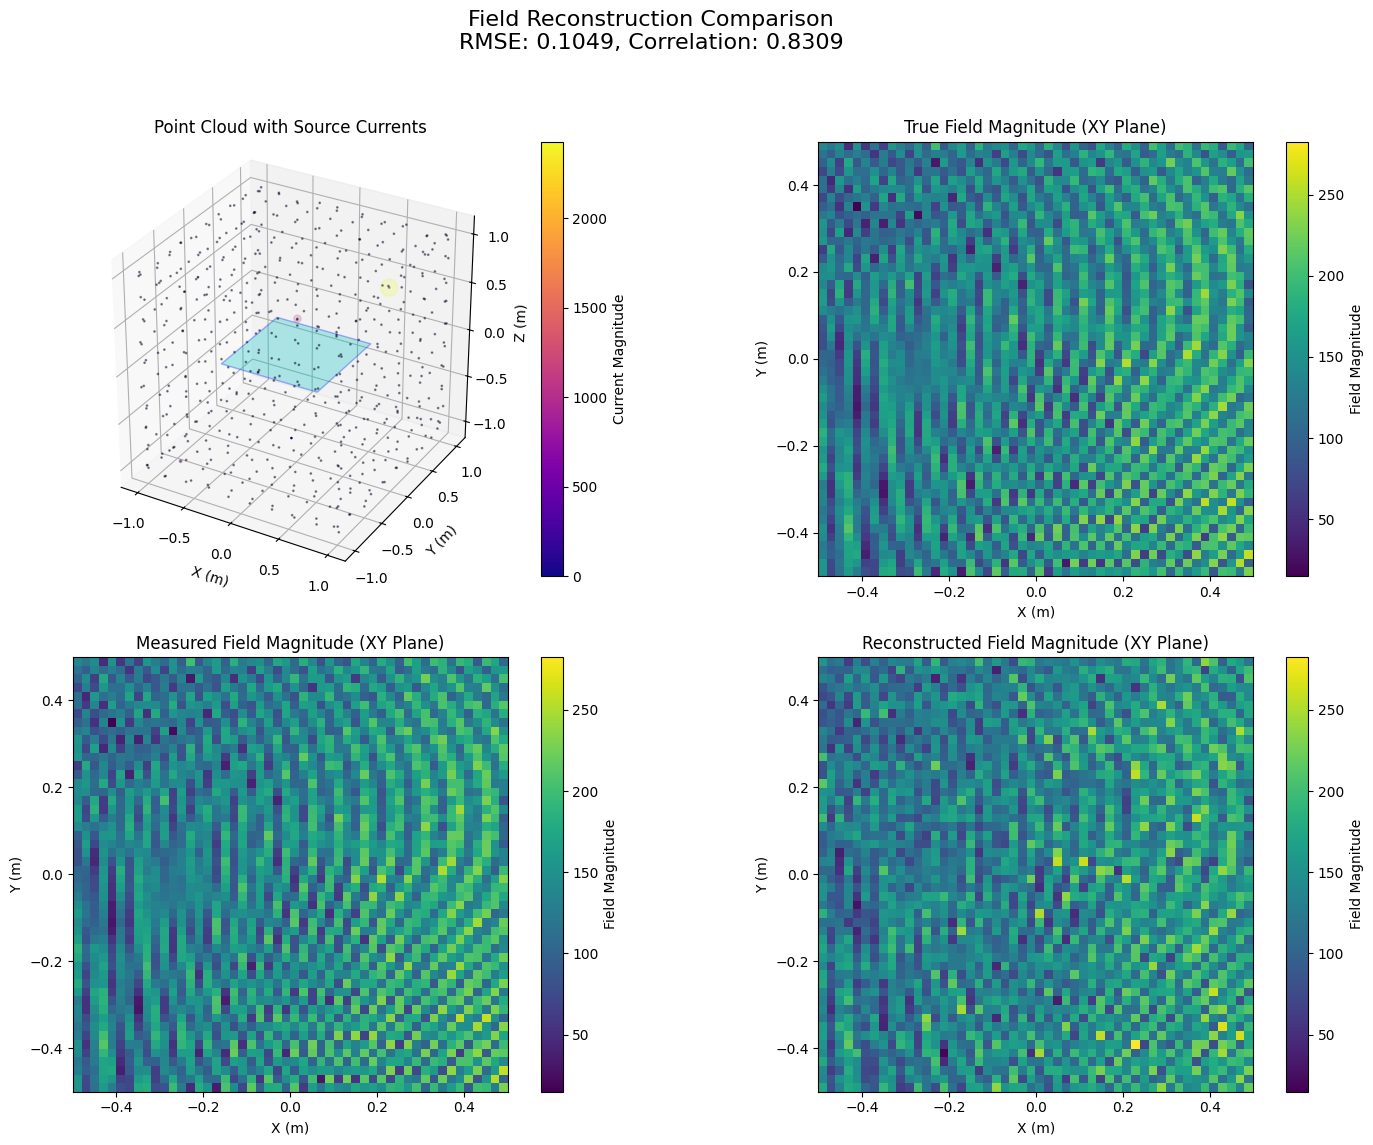

INFO:__notebook__:Final comparison plot saved in ./plots_simulated/


In [14]:
if not cfg.no_plot and all(v is not None for v in [points, currents, measurement_plane, true_field_2d, measured_magnitude_2d, reconstructed_field_2d, rmse, corr]):
    logger.info("Generating final field comparison visualization...")
    try:
        visualize_fields(
            points,
            currents, # Ground truth currents
            measurement_plane,
            true_field_2d,
            measured_magnitude_2d,
            reconstructed_field_2d,
            rmse,  # Calculated RMSE
            corr,  # Calculated Correlation
            show_plot=cfg.show_plot,
            output_dir=output_dir # Pass the output directory
        )
        logger.info(f"Final comparison plot saved in {output_dir}")
    except Exception as e:
        logger.error(f"Error generating final plot: {e}")
elif cfg.no_plot:
    logger.info("Plot generation disabled via no_plot flag")
else:
    logger.warning("Skipping final plot generation due to missing data.")

## End of Notebook